The purpose of this script is to demonstrate the following:
-clip NAIP imagery to a sensible scale based on tower location
-generate a single footprint from a dataset (vector)
-convert the vectorized foorptint into a raster (as of 240814 RS)

We will continue to update this script as we make additional progress. These samples will then be used to generate "final" scripts for Brandon SL footprint project.

###Mount Drive

In [1]:
# Brandon, you should have access to the "root" drive now. That means you won't
# have to point to a different directory anymore!!!

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Install any additional libraries

In [2]:
pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.6 MB/s eta 0:00:00


In [3]:
pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00


###Append sys path to point to FFP script

In [5]:
import sys

In [6]:
DIR = '/content/drive/Shareddrives/WATRS_Field_Data/Student_Projects/B_SanLuis'
sys.path.append(DIR + '/Scripts')

###Import Dependencies

In [7]:
import matplotlib.pyplot as plt
import rioxarray as rxr
from rasterio import features
from rasterio.plot import show
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import calc_footprint_FFP as ffp
import pandas as pd
import pyproj as proj
import numpy as np
import geopandas as gpd
import shapely.plotting
from shapely.geometry import Polygon
import numpy as np
import json

###Set additional directories

In [8]:
CropConcern = 'Broccoli2023' #Change between Broccoli and Lettuce

if CropConcern == 'Broccoli2023' :
  in_df = DIR + '/Data/1_Intermediate_Datasets/Broccoli/Broccoli2023FP.csv'
  NAIP_in = DIR + '/Shapefiles/NAIP_imagery/m_3612137_ne_10_060_20220514/m_3612137_ne_10_060_20220514.tif'
  lat,lon = 36.4593, -121.3877

###Import NAIP image and clip to reasonable size based on tower location

In [9]:
#import NAIP image
naip_image = rxr.open_rasterio(NAIP_in, masked=True)

In [10]:
#get coordinate reference system for later use
naip_crs = es.crs_check(NAIP_in)

In [11]:
#convert tower location coords
station_coord = (lon, lat)
# get EPSG code from lat,long, convert to UTM
EPSG=32700-np.round((45+lat)/90.0)*100+np.round((183+lon)/6.0)
EPSG = int(EPSG)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-11-d879c5043e1f>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  (station_x,station_y) = proj.transform(in_proj,out_

In [12]:
#verify now in UTM
station_x, station_y

(644471.1350075827, 4036101.617475847)

In [13]:
#create a buffer of x meters around the tower to clip to
buffer = 300                                                                    # meters from station
st_lt = station_x - buffer
st_rt = station_x + buffer
st_tp = station_y + buffer
st_bt = station_y - buffer

In [14]:
#create an object using the clip function using values from above
naip_clip_station = naip_image.rio.clip_box(
    minx=st_lt,
    miny=st_bt,
    maxx=st_rt,
    maxy=st_tp,
)

In [15]:
#get extent for plotting
clip_plotting_extent = plotting_extent(naip_clip_station[0], naip_clip_station.rio.transform())

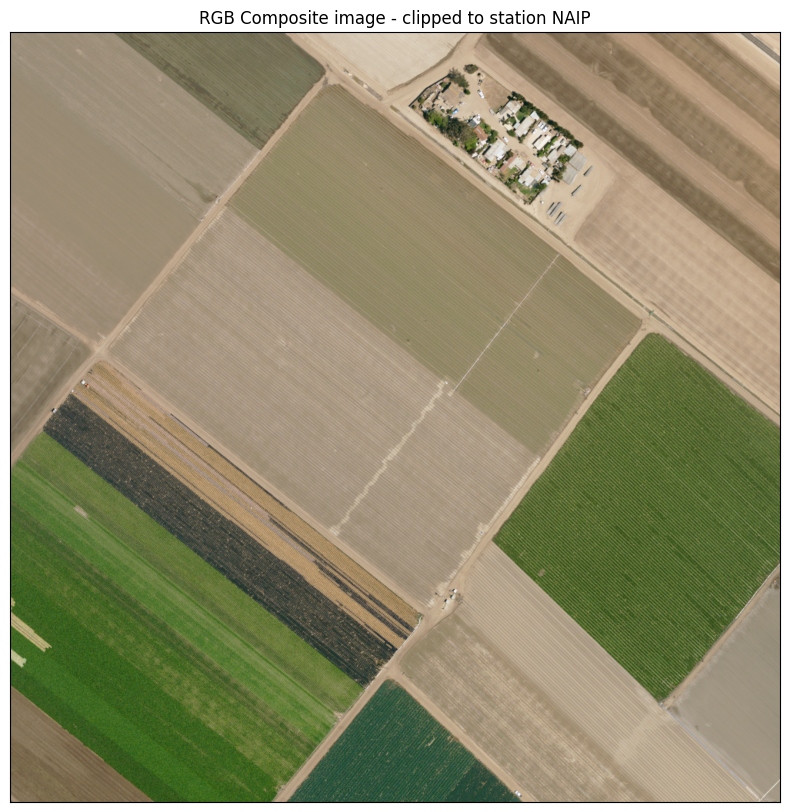

In [16]:
#plot w/ the clipped to station location object
ep.plot_rgb(naip_clip_station.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - clipped to station NAIP",
            extent = clip_plotting_extent)
plt.show()

###Generate a footprint for a single timestep and plot

In [17]:
#import dataframe (already cleaned)
crop_df = pd.read_csv(in_df)

In [18]:
#grab a single timestep
tmp = crop_df.loc[0]

In [19]:
#create footprint
FFP = ffp.FFP(
    zm=tmp.zm - tmp.d,
    z0=0.05,                    #forced to 0.05
    umean=tmp.u_mean,
    h=2000,
    ol=tmp.L,
    sigmav=tmp.sigma_v,
    ustar=tmp.u_star,
    wind_dir=tmp.wind_dir,      #optional
    rs = [90],                  #optional I want the 90th percentile
    #nx = 600,                  #optional
    #rslayer = 1,               #optional
    #crop = 1,                  #optional
    fig=0                       #don't need to show the figure
    )



Error(0009):
 ustar (friction velocity) must be >=0.1.

Alert(0013):
 Using z0, ignoring umean if passed.


In [20]:
#print(i)
#offset coordinate pairs
xs = np.array(FFP['xr'][0])+station_x
ys = np.array(FFP['yr'][0])+station_y

In [21]:
#create the point pairs for exporting
latitude_pts = ys
longitude_pts = xs
#zip pairs and create polygon
polygon_geom = Polygon(zip(longitude_pts, latitude_pts))

In [22]:
#set crs for polygon
poly = gpd.GeoSeries(polygon_geom, crs = naip_crs)

In [23]:
poly

,0
0,"POLYGON ((644471.449 4036102.903, 644471.381 4..."


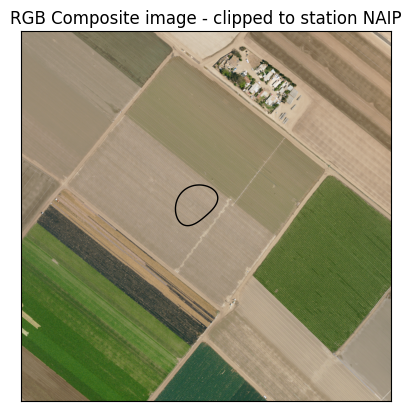

In [24]:
f, ax = plt.subplots()

#plot w/ the clipped to station location object
ep.plot_rgb(naip_clip_station.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - clipped to station NAIP",
            extent = clip_plotting_extent,
            ax = ax
            )
poly.plot(edgecolor = 'black',
          facecolor = 'none',
          ax = ax)
plt.show()

###Generate a second footprint/add to GeoSeries/plot both
###this may need to be done as a geoDataframe NOT a geoSeries

In [ ]:
#grab second timestep
tmp2 = crop_df.loc[1]

In [ ]:
#create footprint
FFP2 = ffp.FFP(
    zm=tmp2.zm - tmp2.d,
    z0=0.05,                    #forced to 0.05
    umean=tmp2.u_mean,
    h=2000,
    ol=tmp2.L,
    sigmav=tmp2.sigma_v,
    ustar=tmp2.u_star,
    wind_dir=tmp2.wind_dir,      #optional
    rs = [90],                  #optional I want the 90th percentile
    #nx = 600,                  #optional
    #rslayer = 1,               #optional
    #crop = 1,                  #optional
    fig=0                       #don't need to show the figure
    )



Alert(0013):
 Using z0, ignoring umean if passed.


In [ ]:
#print(i)
#offset coordinate pairs
xs2 = np.array(FFP2['xr'][0])+station_x
ys2 = np.array(FFP2['yr'][0])+station_y

In [ ]:
#create the point pairs for exporting
latitude_pts2 = ys2
longitude_pts2 = xs2
#zip pairs and create polygon
polygon_geom2 = Polygon(zip(longitude_pts2, latitude_pts2))

In [ ]:
#set crs for polygon
poly2 = gpd.GeoSeries(polygon_geom2, crs = naip_crs)

In [ ]:
#concattenate the two geoSeries objects
poly = pd.concat([poly,poly2])

In [ ]:
#now it should have 2 rows of polygon info!
poly

,0
0,"POLYGON ((644471.449 4036102.903, 644471.381 4..."
0,"POLYGON ((644470.515 4036102.830, 644470.429 4..."


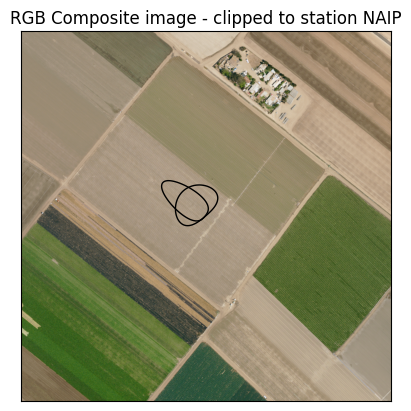

In [ ]:
f, ax = plt.subplots()

#plot w/ the clipped to station location object
ep.plot_rgb(naip_clip_station.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - clipped to station NAIP",
            extent = clip_plotting_extent,
            ax = ax
            )
poly.plot(edgecolor = 'black',
          facecolor = 'none',
          ax = ax)
plt.show()

###rasterize? This still needs work

In [ ]:
poly

,0
0,"POLYGON ((644471.449 4036102.903, 644471.381 4..."
0,"POLYGON ((644470.515 4036102.830, 644470.429 4..."


In [ ]:
geom = [shapes for shapes in poly.geometry]

In [ ]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = naip_clip_station.rio.shape,
                                fill = 0,
                                out = None,
                                transform = naip_clip_station.rio.transform(),
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

<Axes: >

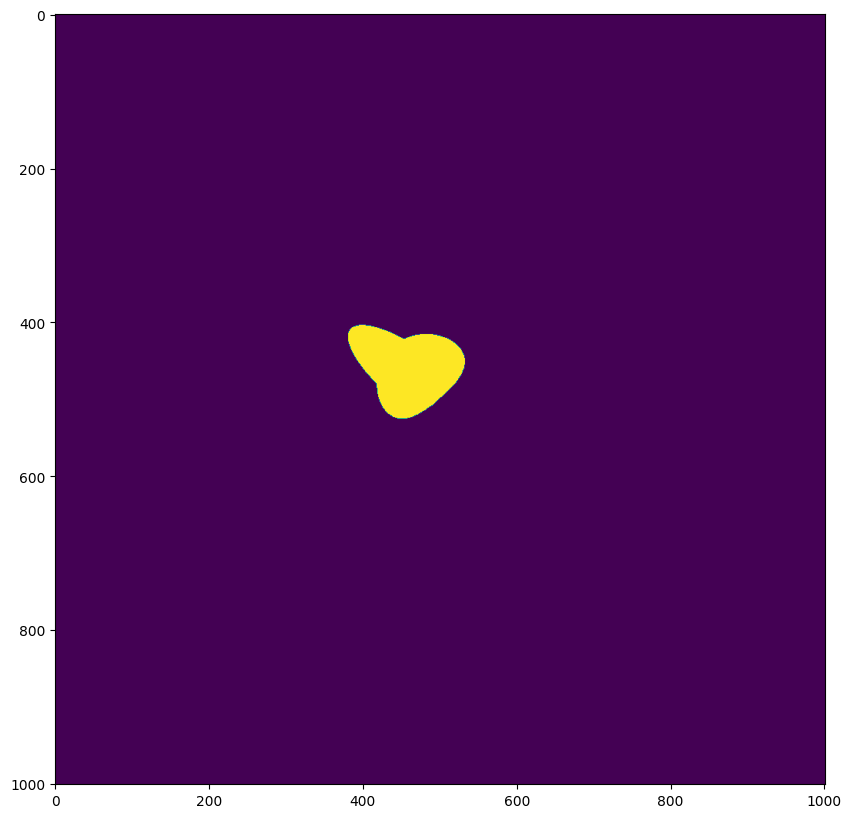

In [ ]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
#this is odd...why is it inverting y-axis?
#plt.gca().invert_yaxis()